In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import RootMeanSquaredError
from scipy.ndimage import uniform_filter1d


Use only feature 'Adj Close'

model 1 

In [2]:
start = '2000-01-01'
end = datetime(2024, 8, 7, 11, 21, 24, 633194)

sp500_data = yf.download('^GSPC', start='2000-03-14', end='2024-01-01')
sp500 = sp500_data.dropna()
print(sp500.head(3))

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-03-14  1383.619995  1395.150024  1359.150024  1359.150024  1359.150024   
2000-03-15  1359.150024  1397.989990  1356.989990  1392.140015  1392.140015   
2000-03-16  1392.150024  1458.469971  1392.150024  1458.469971  1458.469971   

                Volume  
Date                    
2000-03-14  1094000000  
2000-03-15  1302800000  
2000-03-16  1482300000  


In [3]:
data = sp500.filter(['Adj Close'])
#convert the dataframe to a numpy array
dataset = data.values
train_data_len = int(np.round(0.8 * dataset.shape[0]))
train_data_len

4790

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:train_data_len, :]
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
#reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(4730, 60, 1)

In [5]:
test_data = scaled_data[train_data_len - 60:, :]
x_test = []
y_test = dataset[train_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test= np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(1198, 60, 1)

In [6]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4730, 60, 1), (4730,), (1198, 60, 1), (1198, 1))

In [7]:
tf.random.set_seed(42)

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
# model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

2024-08-15 20:00:26.130469: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-08-15 20:00:26.130489: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-08-15 20:00:26.130495: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-08-15 20:00:26.130508: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-15 20:00:26.130519: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When 

Epoch 1/2


2024-08-15 20:00:27.614848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1892/1892 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - loss: 5.2718e-04 - val_loss: 8.7614e-05
Epoch 2/2
1892/1892 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 5.3523e-05 - val_loss: 6.1682e-05


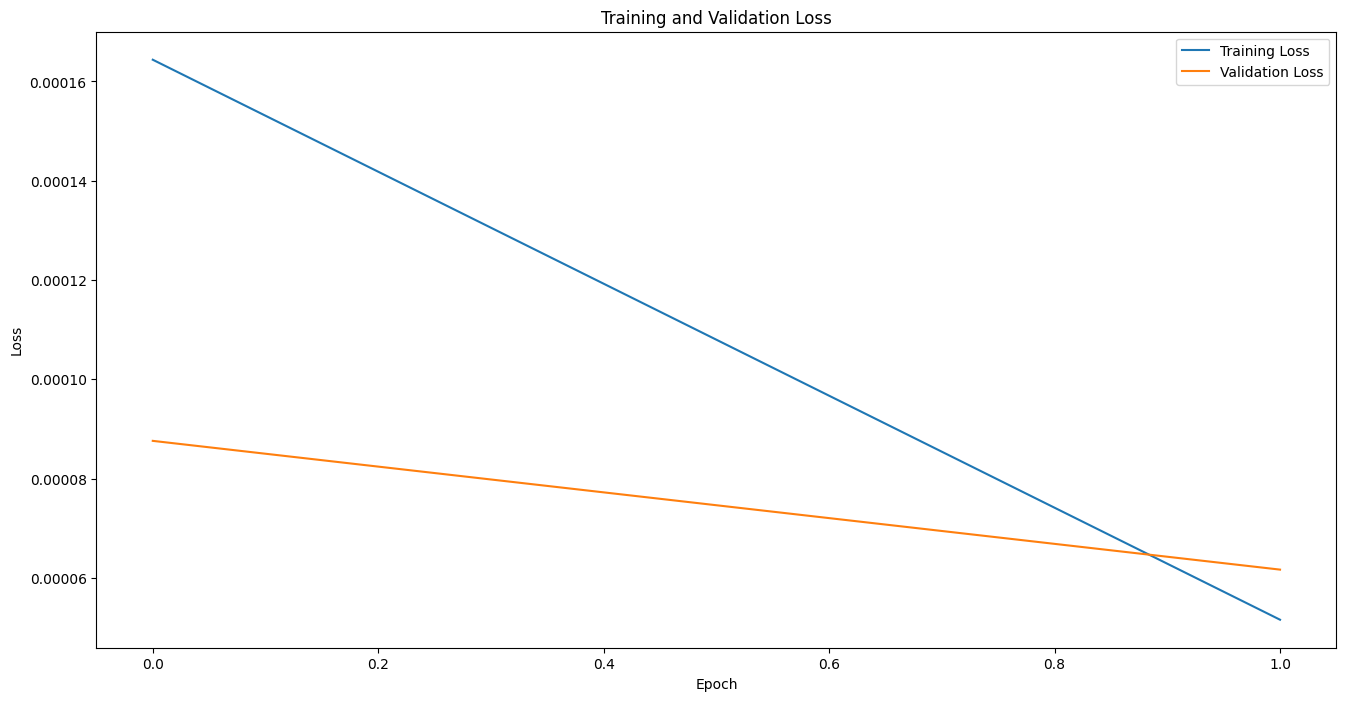

In [8]:
history=model.fit(x_train,y_train,epochs=2,batch_size=2,validation_split=0.2)

# Plot the training and validation loss
plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
#get the root mean squared error (RMSE)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


67.98050694295429

We can see both from our rmse and the train validation loss mour model here did a terriable job, however, when look at the model below, it looks we get a good resutls anyway. 

/var/folders/py/r18r2psx509b19yt58bj8b300000gn/T/ipykernel_76291/3729137219.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


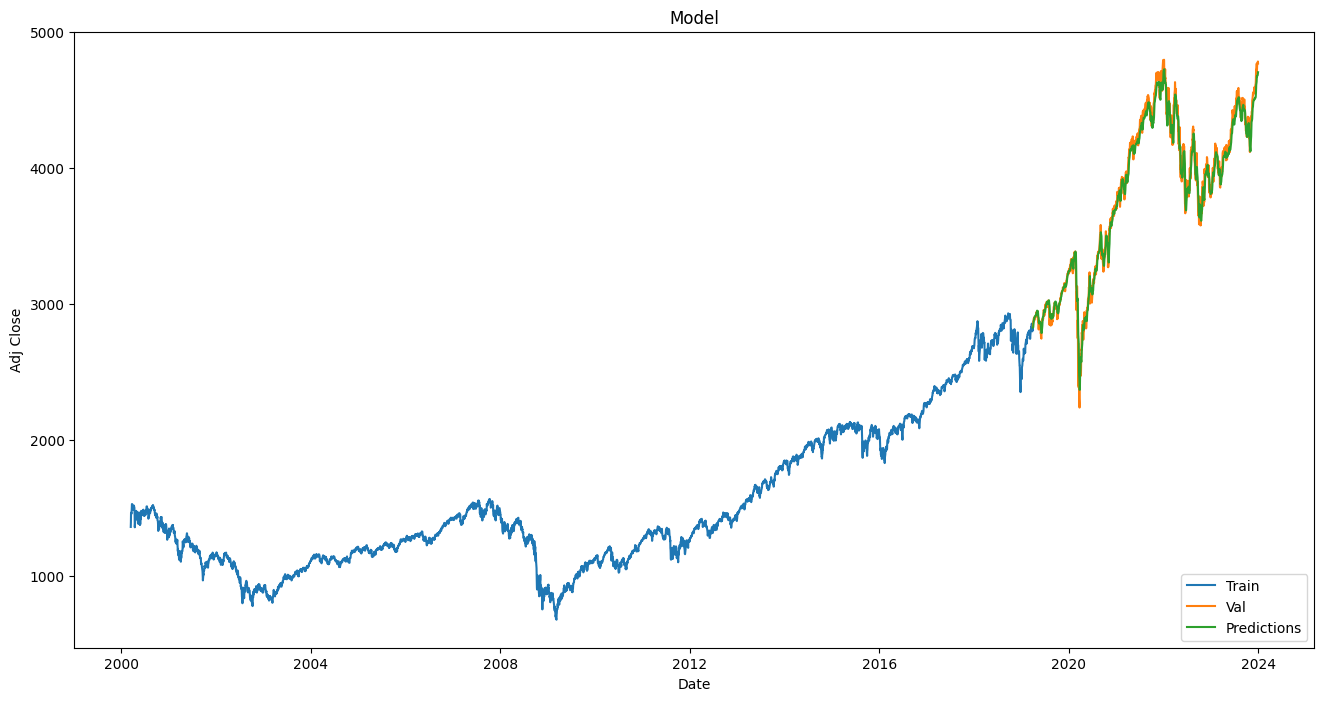

In [10]:
train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

/var/folders/py/r18r2psx509b19yt58bj8b300000gn/T/ipykernel_76291/1264031377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


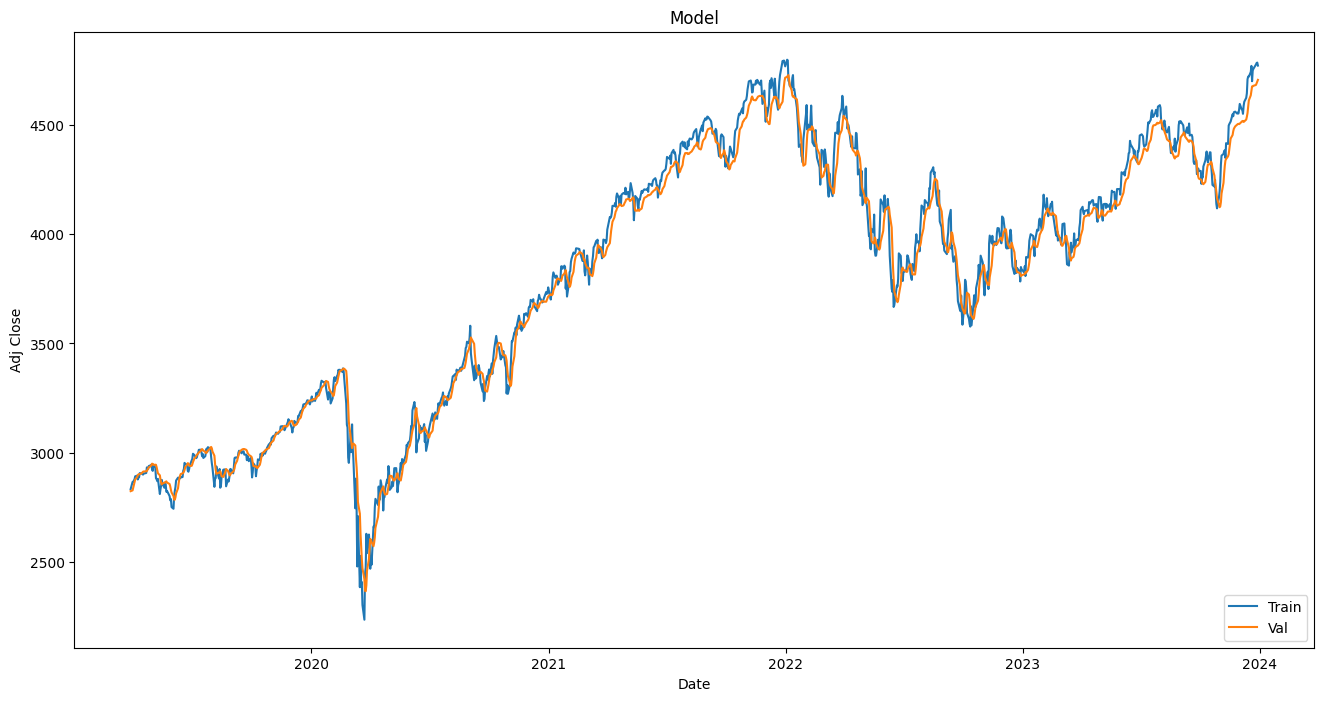

In [11]:
valid = data[train_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

Reference: https://youtu.be/QIUxPv5PJOY?si=ptQ9CsgGO4wv_K0N